In [1]:
# install.packages("rdist")
# install.packages("cba")
# install.packages("ggnewscale")
dotenv::load_dot_env()

# Setup

In [1]:
BUCKET = Sys.getenv("PREDICT_BUCKET")

In [339]:
system(sprintf("gsutil -m rsync -r %s/curated_rfcorrespondenceplots  ~/randomforest/rf_comp_plts", BUCKET))

In [340]:
list.files("~/randomforest/rf_comp_plts")

[1] "20200424-161845_Mloid" "20200424-161846_Fibro" "20200424-161847_Bclls"
 [4] "20200424-161849_Tclls" "20200424-161850_Epith" "20200522-173047_Endth"
 [7] "20200624-164843_Tclls" "20200701-140658_Mloid" "20200702-152814_Mloid"
[10] "20200702-182132_Tclls" "20200703-131537_Epith" "20201112-151456_Mloid"
[13] "20201112-151457_Fibro" "20201112-151458_Bclls" "20201112-151459_Tclls"
[16] "20201112-151500_Epith" "20201112-151501_Endth" "20201112-233922_Fibro"
[19] "logging"

In [8]:
system(sprintf("gsutil -m cp -r %s/Tiered-FGID-13/%s ~/FG13/%s",
               BUCKET,
               "20200630_clmeta_FG13_all.tsv",
               "20200630_clmeta_FG13_all.tsv"))
system(sprintf("gsutil -m cp -r %s/Tiered-CD-14/%s ~/CD14/%s",
               BUCKET,
               "20200630_clmeta_CD14_all.tsv",
               "20200630_clmeta_CD14_all.tsv"))

In [4]:
library(Seurat)
library(tidyverse)
library(broom)
library(ggplot2)
library(ggdendro)
library(gridExtra)
library(ggpubr)
library(ggnewscale)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




In [68]:
OUTDIR = Sys.getenv("FIGDIR")
dir.create(OUTDIR)

In [125]:
fgid_meta = read.table("~/FG13/20200630_clmeta_FG13_all.tsv", sep="\t",  header=1)
cd14_meta = read.table("~/CD14/20200630_clmeta_CD14_all.tsv", sep="\t",  header=1)
# cd14_meta = read.table("~/CD14/20200422_clmeta_CD14_all.tsv", header=1)
# cd14_meta$tierNname = gsub("^Hs", "CD", cd14_meta$tierNname)

In [75]:
sigtest.df = read.table(
    file="~/CD14/fraqsigtests/20200703_AllCuratedNames_MWtest_CPM_subsetbycelltype.tsv",
    sep="\t", header=1)

In [341]:
celltype_folders = c(
# #"20200424-161845_Mloid",
# "20200424-161847_Bclls",
# #"20200424-161850_Epith",
# "20200424-161846_Fibro",
# #"20200624-161849_Tclls",
# "20200522-173047_Endth",
# "20200702-182132_Tclls",
# "20200702-152814_Mloid",
# "20200703-131537_Epith",
    '20201112-151458_Bclls',
    '20201112-233922_Fibro',
    '20201112-151501_Endth',
    '20201112-151459_Tclls',
    '20201112-151456_Mloid',
    '20201112-151500_Epith'
    
)

Manually run notebook for each cell type folder by changing `ct.idx`

In [342]:
ct.idx = 2

In [343]:
clust_height = 0.7 # 0.6 for Tclls

In [344]:
celltype.colors <- c(
    #"CD.Mloid" = '#8C564B',
    "CD.Bclls" = '#1F77B4',
    #"CD.Epith" = '#3BA63B',
    "CD.Fibro" = '#D62728',
    #"CD.Tclls" = '#1ABECF',
    "CD.Endth" = '#FF9B45',
    "CD.Tclls" = '#1ABECF',
    "CD.Mloid" = '#8C564B',
    "CD.Epith" = '#3BA63B'
#     "CD.Paneth" = '#99C699',
#     "CD.Mstcl" = '#E586C8',
#     "CD.IGA_IGL_Plsma"= '#7F7F7F',
#     "CD.IGA_Plsma" = '#7F7F7F',
#     "CD.IGG_Plsma" = '#3F3F3F',
#     "CD.IGM_Plsma"= '#BFBFBF'
)
ct = names(celltype.colors)[ct.idx]

# start making plots

In [345]:
fgid_preds = read.table(
    sprintf("~/randomforest/rf_comp_plts/%s/preds_FGID13_on_CD14.tsv", celltype_folders[ct.idx]),
    check.names=FALSE, sep="\t", header=1)
cd14_preds = read.table(
    sprintf("~/randomforest/rf_comp_plts/%s/preds_CD14_on_FGID13.tsv", celltype_folders[ct.idx]),
    check.names=FALSE, sep="\t", header=1)

In [346]:
# get probs as aggregated matrix
probsFG = fgid_preds %>%
    filter(manualannotation %in% colnames(cd14_preds)) %>%
    subset(select=-c(CellID, cellsubsetspreds)) %>%
    aggregate(. ~ manualannotation, ., mean) %>%
    column_to_rownames("manualannotation")
# rownames(probsFG) = gsub("Hs.", "FG.", rownames(probsFG))
# colnames(probsFG) = gsub("Hs.", "CD.", colnames(probsFG))
# rownames(probsFG) = paste0("FG.", rownames(probsFG))
# colnames(probsFG) = paste0("CD.", colnames(probsFG))

probsCD = cd14_preds %>%
    filter(manualannotation %in% colnames(fgid_preds)) %>%
    subset(select=-c(CellID, cellsubsetspreds)) %>%
    aggregate(. ~ manualannotation, ., mean) %>%
    column_to_rownames("manualannotation")
# rownames(probsCD) = gsub("Hs.", "CD.", rownames(probsCD))
# colnames(probsCD) = gsub("Hs.", "FG.", colnames(probsCD))
# rownames(probsCD) = paste0("CD.", rownames(probsCD))
# colnames(probsCD) = paste0("FG.", colnames(probsCD))
print(probsFG %>% dim)
print(probsCD %>% dim)

[1] 23 45
[1] 45 23


In [349]:
# Calculate dendrograms based on prediction similarity
options(repr.plot.height=10, repr.plot.width=10)
fgD = rdist::rdist(probsFG, metric="correlation")
fglinks = hclust(fgD, method="complete")
co = cba::order.optimal(fgD, fglinks$merge)
fglinks$merge = co$merge
fglinks$order = co$order
# fglinks$labels = gsub("Hs.", "FG.", fglinks$labels)
fglinks$group = cutree(fglinks, h= (clust_height * max(fglinks$height)))
fg.ord.labs = fglinks$labels[fglinks$order]

cdD = rdist::rdist(probsCD, metric="correlation")
cdlinks = hclust(cdD, method="complete")
co = cba::order.optimal(cdD, cdlinks$merge)
cdlinks$merge = co$merge
cdlinks$order = co$order
# cdlinks$labels = gsub("Hs.", "CD.", cdlinks$labels)
cdlinks$group = cutree(cdlinks, h= (clust_height * max(cdlinks$height)))
cd.ord.labs = cdlinks$labels[cdlinks$order]

In [350]:
# calculate correspondence matrix for dotplot
dot = (probsFG[fglinks$labels[fglinks$order], cdlinks$labels[cdlinks$order]] - 
       t(probsCD[cdlinks$labels[cdlinks$order], fglinks$labels[fglinks$order]])) %>%
    rownames_to_column("fg") %>%
    gather(cd, bias, -fg)

dot$correspondence = (probsFG[fglinks$labels[fglinks$order], cdlinks$labels[cdlinks$order]] + 
                      t(probsCD[cdlinks$labels[cdlinks$order], fglinks$labels[fglinks$order]])) %>%
    rownames_to_column("fg") %>%
    gather(cd, correspondence, -fg) %>%
    .$correspondence

In [351]:
substring(ct, 4)

[1] "Fibro"

In [352]:
dot$fggroup = fglinks$group[dot$fg]
dot$cdgroup = cdlinks$group[dot$cd]

In [353]:
dot %>% write.table(
    file.path("~/randomforest/correspondencedata", paste0(substring(ct, 4), "_dotmetrics.tsv")),
    sep="\t",
    row.names=FALSE)

In [354]:
cd14_meta$type %>% levels

[1] "Bclls"          "Doubets/Fibro"  "Doublets/Bclls" "Doublets/Endth"
 [5] "Doublets/Epith" "Doublets/Fibro" "Doublets/Mloid" "Doublets/Mstcl"
 [9] "Doublets/Plsma" "Doublets/Tclls" "Endth"          "Epith"         
[13] "Fibro"          "LowQual/Epith"  "LowQual/Mloid"  "LowQual/Tclls" 
[17] "Mloid"          "Mstcl"          "Plsma"          "Tclls"

In [355]:
# calculate CPM matrix for frequency plot
# ct.meta = cd14_meta %>% filter(tier1name %in% c(ct, "CD.Epith_Paneth") & is_doublet=="False")
ct.meta = cd14_meta %>% 
    filter(type == substring(ct, 4), 
           !grepl("(Doublets)|(LowQual)", type)
          ) %>%
#     mutate(curatedname = paste0("CD.", curatedname)) %>%
    select(curatedname, patient, antiTNF_response) %>%
    setNames(c("subset", "patient", "ATR")) %>%
    mutate(ATR = plyr::revalue(ATR, c("RESP"="FR")))

In [356]:
# calculate diversity for CD subsets by patient
diversity = ct.meta %>%
    mutate(subset = factor(subset)) %>%
    group_by(subset) %>%
    summarize(diversity = 1 - sum(((table(patient)) / (length(patient)))^2)) %>%
    column_to_rownames("subset") %>%
    .[cd.ord.labs, ,drop=FALSE]
diversity$subset = rownames(diversity)
# diversity$tierNname = gsub("^Hs", "CD", diversity$tierNname)

In [357]:
tbl = ct.meta %>%
    group_by(ATR, subset, patient) %>%
    summarize(count = length(patient)) %>%    
    group_by(patient) %>%
    mutate(normcount = ((count / sum(count)) * 1e6)) %>% 
    group_by(ATR, subset) %>% 
    summarize(value=mean(normcount)) %>% 
    reshape2::dcast(subset ~ ATR, value.var = "value") %>% 
    replace_na(list(NOA=0, PR=0, FR=0)) %>%
    column_to_rownames("subset") %>%
    .[, c("NOA", "FR", "PR")] %>%
    array %>% as.table %>% prop.table(margin=1) %>% 
    setNames(c("NOA", "FR", "PR"))

In [358]:
pltfrac.df = reshape2::melt(rownames_to_column(tbl, "subset"), id.vars="subset")
cpm.df = as.data.frame(table(factor(ct.meta$subset),
                        paste0(ct.meta$patient,"-", ct.meta$ATR))) %>%
        separate("Var2", c("Var2", "Var3")) %>%
        setNames(c("subset", "patient", "ATR", "count")) %>%   
        group_by(patient) %>%
        mutate(normcount = ((count / sum(count)) * 1e6))

In [359]:
table(ct.meta$ATR)


 NOA   PR   FR 
 798 2131 2070 

In [360]:
perform_MW_test = function(ct.meta, 
                           subset_col="subset", 
                           group_col="ATR", 
                           control_col="patient",
                           comparisons=list(c("NOA", "FR"), c("NOA", "PR"), c("FR", "PR"))) {
    tbl = as.data.frame(table(factor(ct.meta[[subset_col]]),
                              paste0(ct.meta[[control_col]],"-", ct.meta[[group_col]]))) %>%
        separate("Var2", c("Var2", "Var3")) %>%
        setNames(c("subset", "patient", "ATR", "count")) %>%   
        group_by(patient) %>%
        mutate(CPM = ((count / sum(count)) * 1e6), sumcount = sum(count))
    
    complist = list()
    for (comp in comparisons) {
        
        suppressWarnings({
        tsttbl = tbl %>% 
            filter(ATR %in% comp) %>%
            group_by(subset) %>%
            do(tidy(wilcox.test(CPM ~ ATR, alternative = "t", data=.)))
        })
        
        tstsmpNs = data.table::rbindlist(lapply(tsttbl$subset,
            function(nm) {
                mean.null = mean(tbl$CPM[tbl$subset == nm & 
                                              tbl$ATR == comp[1]])
                mean.altr = mean(tbl$CPM[tbl$subset == nm & 
                                              tbl$ATR == comp[2]])
                sd.full = sd(tbl$CPM[tbl$subset == nm])
                data.frame(
                    subset = as.character(nm),
                    mean.null = mean.null,
                    mean.altr = mean.altr,
                    avg_log2FC = log2(mean.altr/mean.null),
                    id.null = comp[1],
                    id.altr = comp[2]
               )
            })
    )
        
        complist[[str_flatten(comp, "vs")]] = merge(tsttbl, tstsmpNs, by="subset")
    }
    return(data.table::rbindlist(complist, idcol="comp_label"))
}

tstdf = perform_MW_test(ct.meta, subset_col="subset", 
                           group_col="ATR", 
                           control_col="patient")

In [361]:
sigplt.df = tstdf %>% filter(p.value < 0.05)
sigplt.df

comp_label,subset,statistic,p.value,method,alternative,mean.null,mean.altr,avg_log2FC,id.null,id.altr
<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
NOAvsFR,CD.Fibro.CCL19.IRF7,0,0.01794281,Wilcoxon rank sum test with continuity correction,two.sided,40534.812,1737.797,-4.543830,NOA,FR
NOAvsPR,CD.Fibro.CCL19.IRF7,19,0.03654634,Wilcoxon rank sum test with continuity correction,two.sided,40534.812,3454.013,-3.552816,NOA,PR
NOAvsPR,CD.Fibro.FIGF.MMP11,20,0.01079959,Wilcoxon rank sum test with continuity correction,two.sided,22889.519,0.000,-Inf,NOA,PR
NOAvsPR,CD.Fibro.IFI6.IFI44L,19,0.02965656,Wilcoxon rank sum test with continuity correction,two.sided,56794.532,3174.603,-4.161104,NOA,PR
FRvsPR,CD.Fibro.AGT.F3,2,0.03614514,Wilcoxon rank sum test with continuity correction,two.sided,7001.133,41355.392,2.562415,FR,PR
FRvsPR,CD.Fibro.LY6H.PAPPA2,2,0.03114121,Wilcoxon rank sum test with continuity correction,two.sided,9178.744,54679.940,2.574643,FR,PR
FRvsPR,CD.Glial.SPP1.NRXN1,24,0.01587302,Wilcoxon rank sum test,two.sided,20714.091,5154.846,-2.006611,FR,PR


In [362]:
sigtst.df = sigtest.df %>% filter(celltype==ct) %>%
    mutate(curatedname=cd14_meta$curatedname[match(subset, cd14_meta$tierNname)])

In [363]:
#any(cd14_meta$curatedname %in% cd.ord.labs[!(cd.ord.labs %in% diversity$subset)])
cd.ord.labs[!(cd.ord.labs %in% diversity$subset)]

character(0)

In [364]:
diversity$subset %>% length

[1] 45

In [365]:
cd.ord.labs %>% length

[1] 45

In [366]:
p1 = ggplot(probsFG %>% 
       rownames_to_column("fg") %>% 
       gather(cd, val, -fg)) +
    geom_tile(aes(y=fg, x=cd, fill=val)) + 
    theme(axis.text.x = element_text(angle=270, size=6, vjust=.5, hjust=0),
          axis.text.y = element_text(size=6),
          legend.position="left") +
    scale_y_discrete(limits=fglinks$labels[fglinks$order], position="right") +
    scale_x_discrete(limits=cdlinks$labels[cdlinks$order]) +
    scale_fill_viridis_c(option="A")

# ggsave(plot=p1,
#        file=file.path(OUTDIR, sprintf("%s_confusionplot_fg.pdf", ct)),
#        useDingbats=FALSE,
#        height=10, width=10)

In [367]:
p2 = ggplot(probsCD %>% 
       rownames_to_column("cd") %>% 
       gather(fg, val, -cd)) +
    geom_tile(aes(y=fg, x=cd, fill=val)) + 
    theme(axis.text.x = element_text(angle=270, size=6, vjust=.5, hjust=0),
          axis.text.y = element_text(size=6),
          legend.position="left") +
    scale_y_discrete(limits=fglinks$labels[fglinks$order], position="right") +
    scale_x_discrete(limits=cdlinks$labels[cdlinks$order]) +
    scale_fill_viridis_c(option="A")

# ggsave(plot=p2,
#        file=file.path(OUTDIR, sprintf("%s_confusionplot_cd.pdf", ct)),
#        useDingbats=FALSE,
#        height=10, width=10)

In [368]:
exp_lims = c(0.03, 0.03)

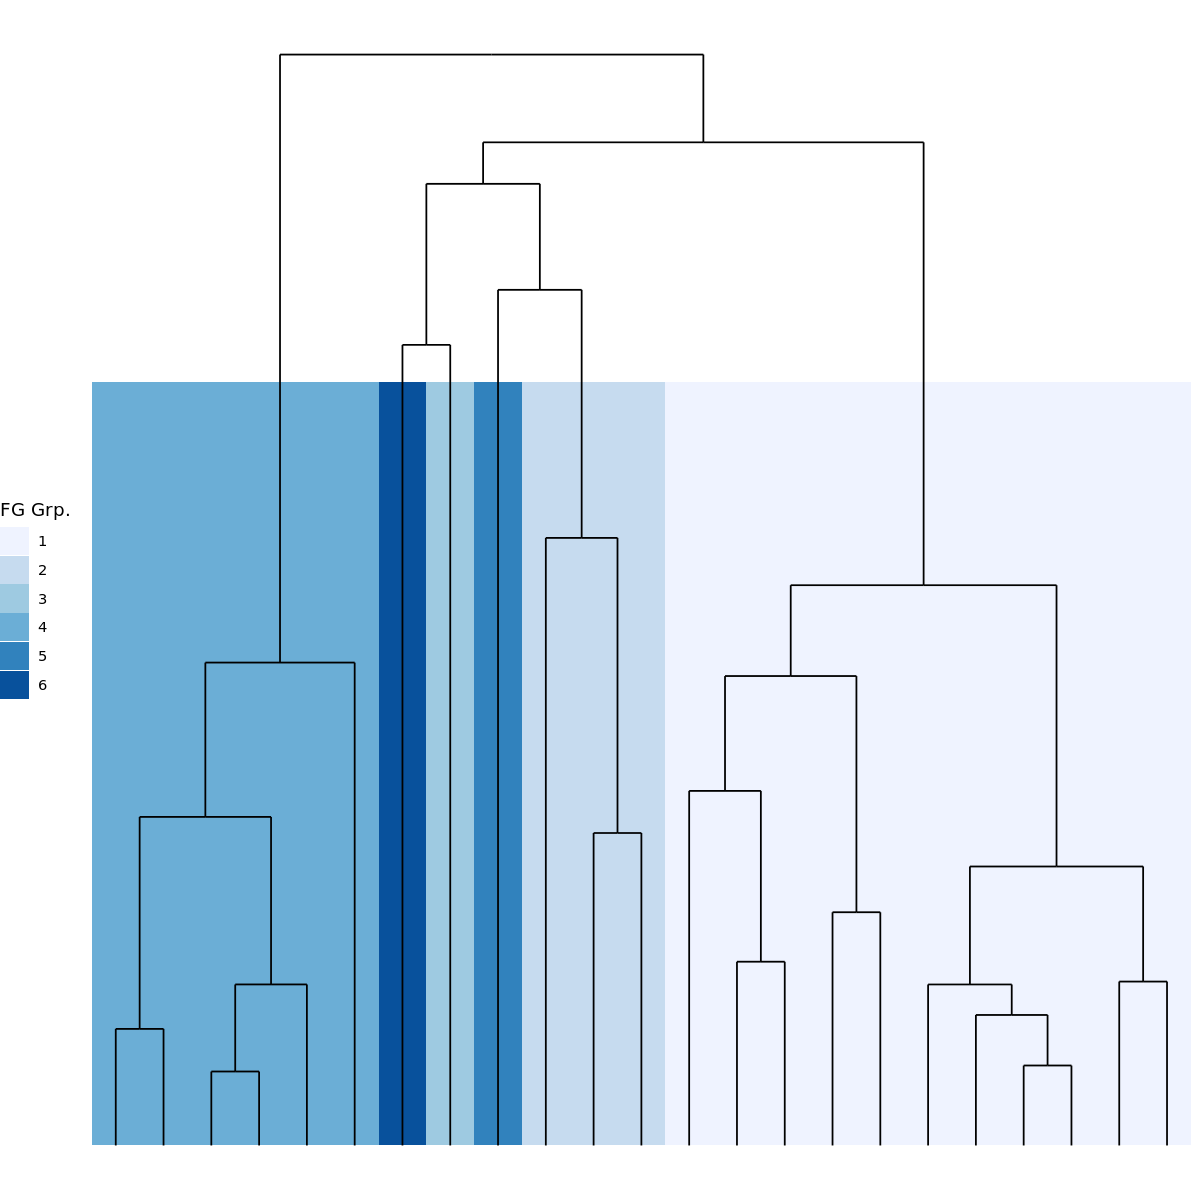

In [369]:
dplotFG = ggplot() + 
    geom_tile(data=data.frame(lab = fglinks$labels[fglinks$order],
                              grp = factor(fglinks$group[fglinks$order])),
                   aes(x=lab, y =(clust_height * max(fglinks$height))*0.5, fill=grp),
                   height = (clust_height * max(fglinks$height))) +
    geom_segment(data=segment(dendro_data(as.dendrogram(fglinks), type = "rectangle")),
                 aes(x = x, y = y, xend = xend, yend = yend)) + 
#     coord_flip() + 
    scale_x_discrete(limits=fg.ord.labs, expand=exp_lims) + 
#     scale_y_reverse() + 
    scale_fill_brewer(name="FG Grp.", palette = "Blues") +
    theme_void() + 
    theme(legend.position="left", legend.direction="vertical")
dplotFG

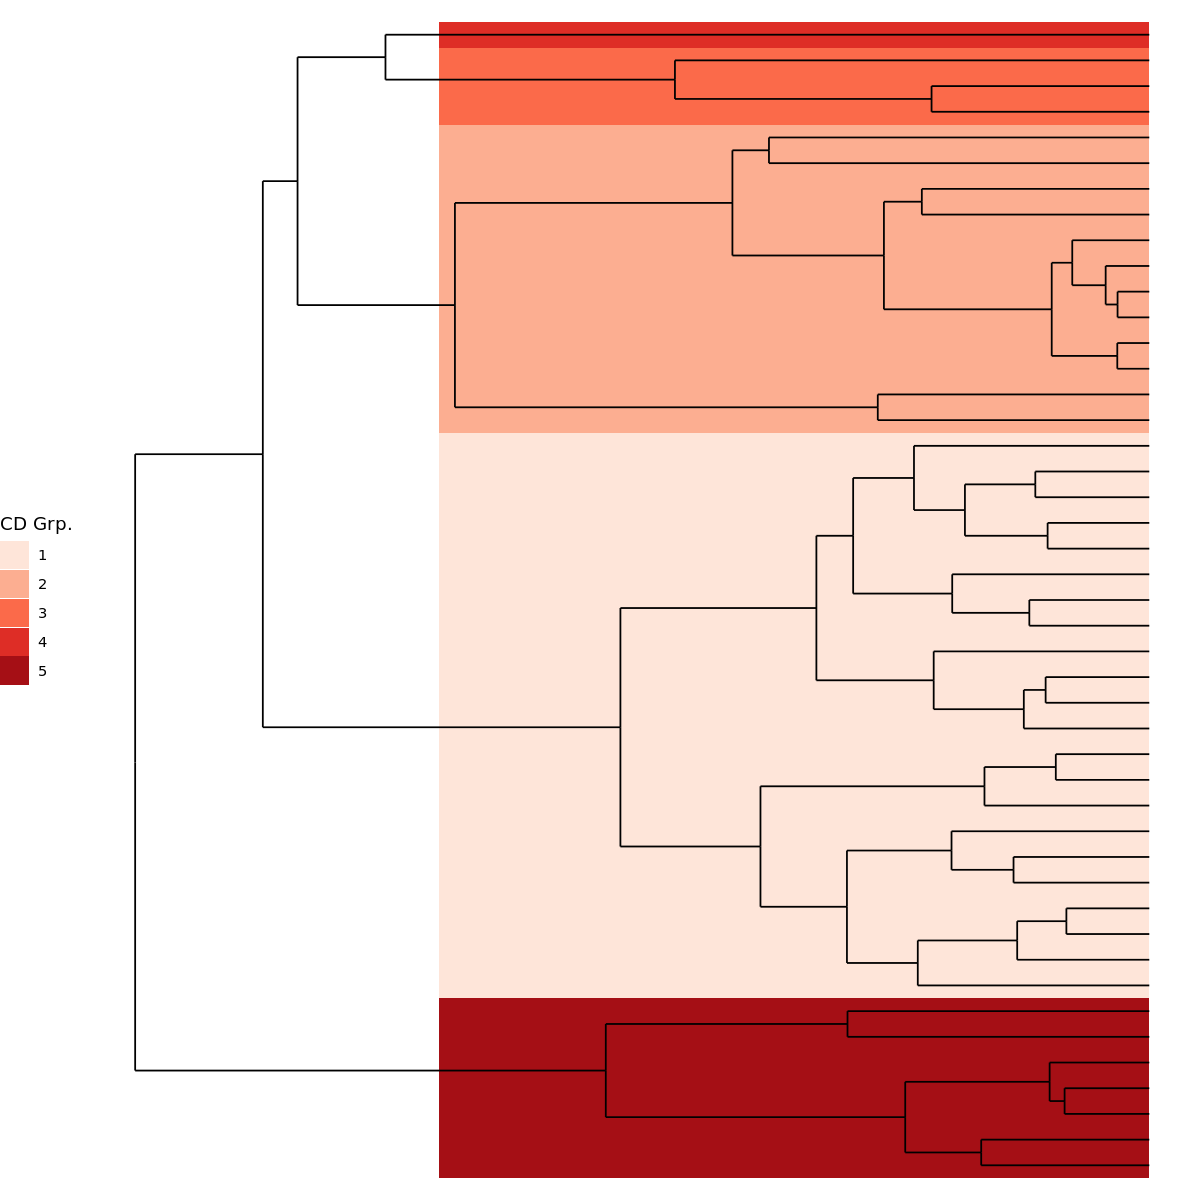

In [370]:
dplotCD = ggplot() + 
    geom_tile(data=data.frame(lab = cdlinks$labels[cdlinks$order],
                              grp = factor(cdlinks$group[cdlinks$order])),
                   aes(x=lab, y =(clust_height * max(cdlinks$height))*0.5, fill=grp), #fill="white",
                   height = (clust_height * max(cdlinks$height))) +
    geom_segment(data=segment(dendro_data(as.dendrogram(cdlinks), type = "rectangle")),
                 aes(x = x, y = y, xend = xend, yend = yend)) +
    coord_flip() + 
    scale_x_discrete(limits=cd.ord.labs, expand=exp_lims) + 
    scale_y_reverse() + 
    scale_fill_brewer(name="CD Grp.", palette = "Reds") +
    theme_void() + 
    theme(legend.position="left")
dplotCD

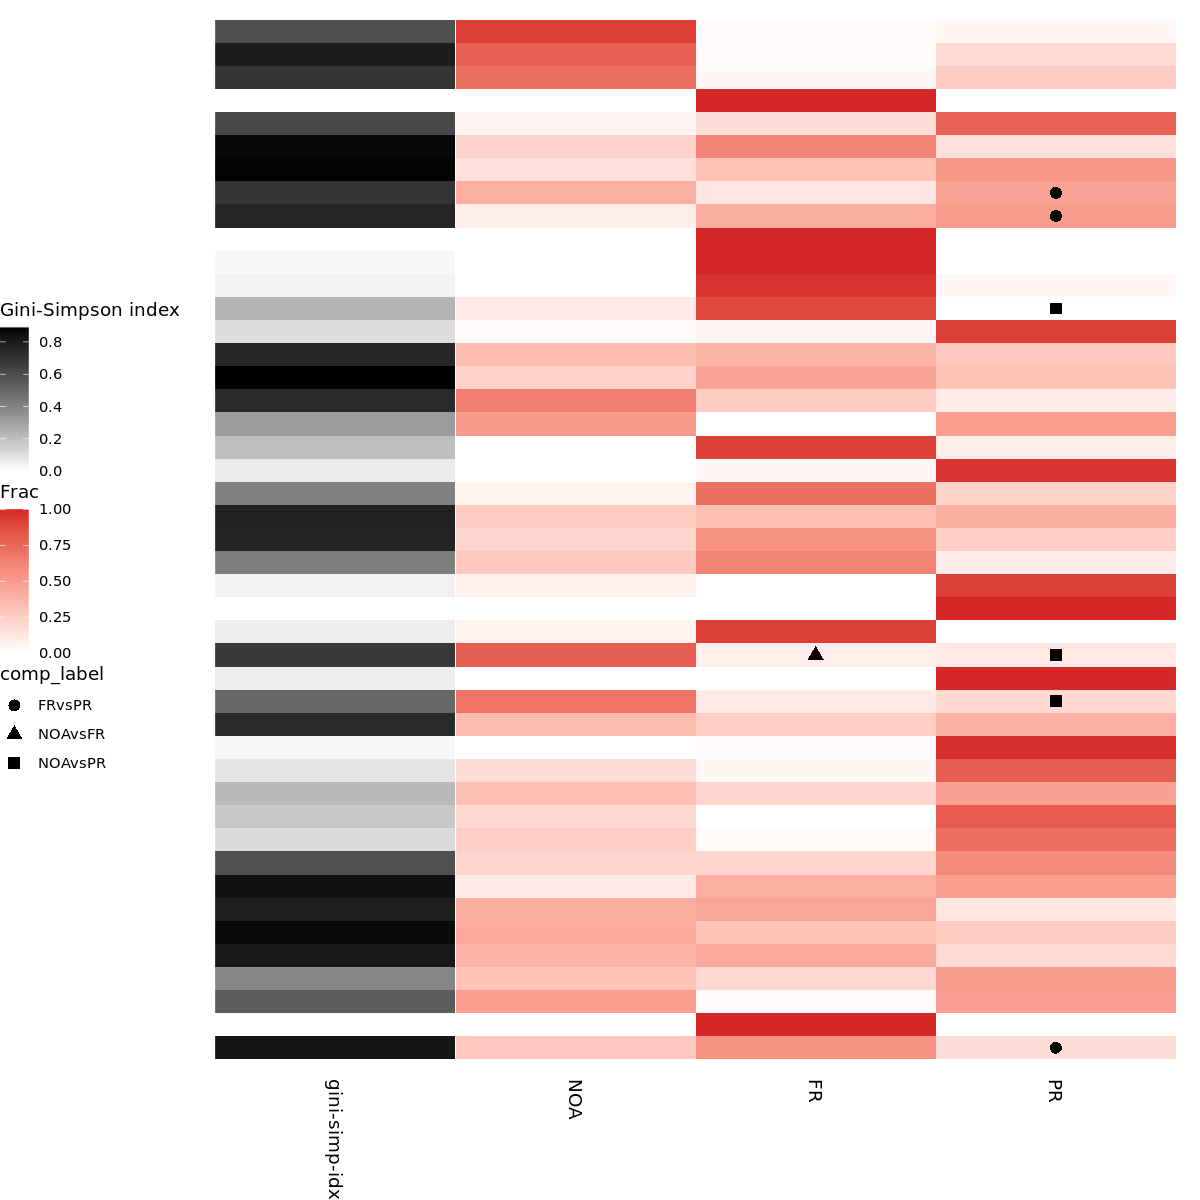

In [371]:
pfrac = ggplot(pltfrac.df) + 
    geom_raster(aes(y = subset, x = variable, fill=value), interpolate=FALSE) +
    scale_fill_gradient(low="white", high=celltype.colors[ct], name="Frac") +
    new_scale_fill() +
    geom_point(data=sigplt.df,
               inherit.aes=FALSE,
               aes(y=subset,
                   x=id.altr,
                   shape=comp_label), size=3) +
    geom_raster(data=diversity, interpolate=FALSE,
                aes(x="gini-simp-idx", y=subset, fill=diversity)) +
    scale_fill_gradient(low="white", high="black", name="Gini-Simpson index") +
    scale_y_discrete(position = "right", limits = cd.ord.labs, expand=exp_lims) +
    scale_x_discrete(limits=c("gini-simp-idx", "NOA", 'FR', "PR")) +
    theme_void() +
    theme(#axis.text.y.right = element_text(size=5, color="black"),
          axis.text.x = element_text(angle=-90, hjust=0, vjust=0.5),
          legend.position="left")
pfrac

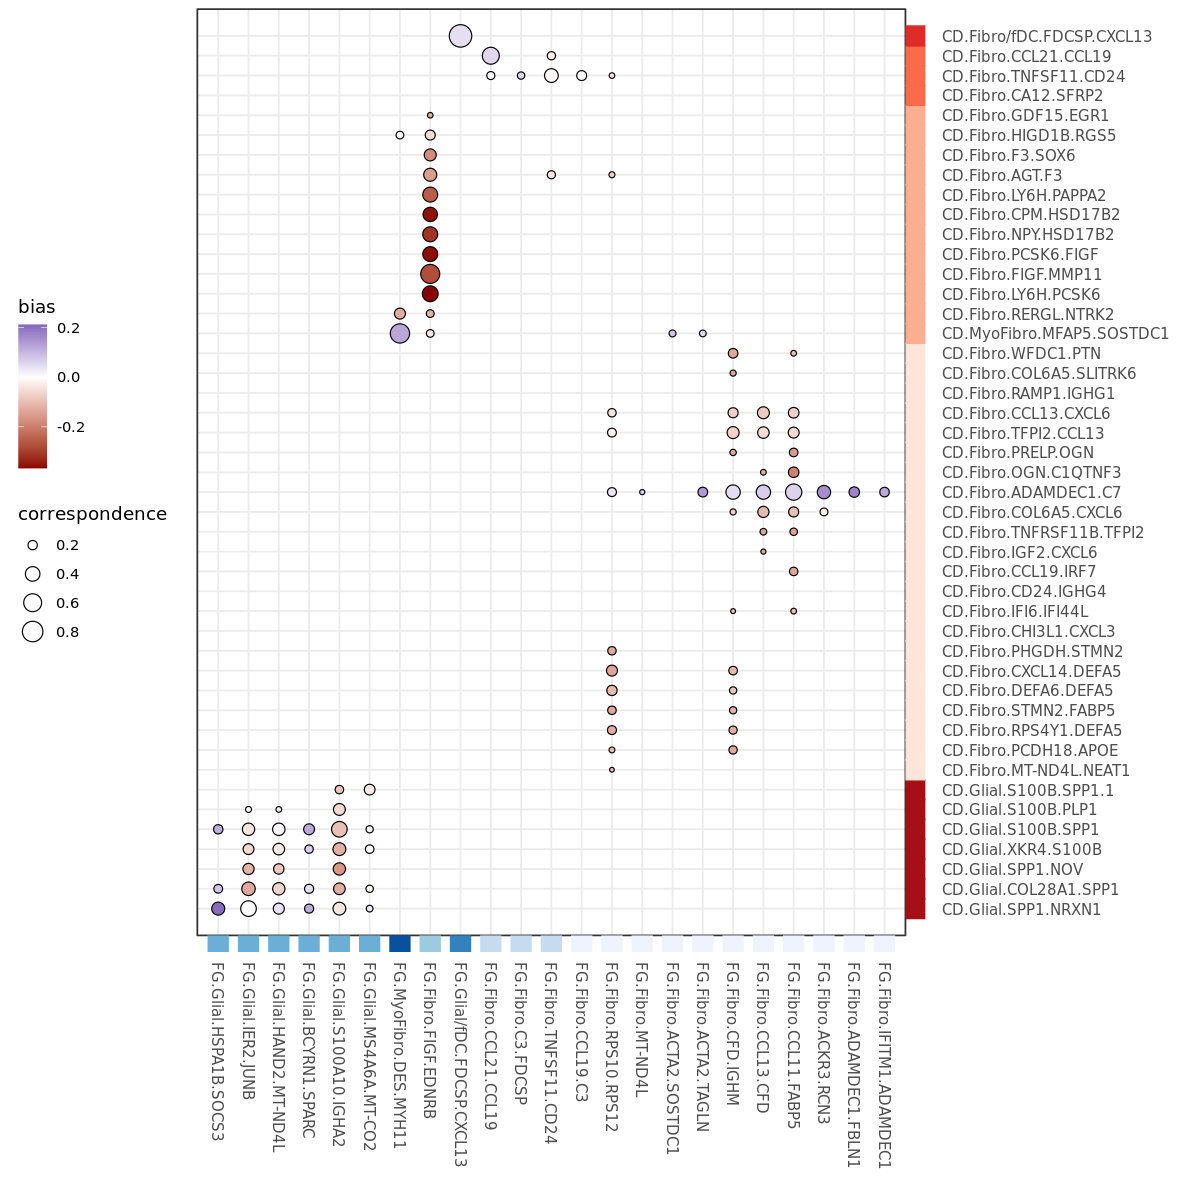

In [372]:
pdot = ggplot(dot[dot$correspondence >= quantile(dot$correspondence, 0.9),]) +
    geom_point(aes(y=cd, x=fg, size=correspondence, fill=bias), colour="black", pch=21) + 
    coord_cartesian(clip="off") +
    scale_x_discrete(limits=fglinks$labels[fglinks$order], expand=exp_lims) +
    scale_y_discrete(limits=cdlinks$labels[cdlinks$order], expand=exp_lims, , position="right") +
    scale_fill_gradient2(low='darkred', mid='white', high='darkblue') +
    theme_bw() + ylab("") + xlab("") +
    theme(axis.ticks.length.x.bottom = unit(10, units = "pt"),
          axis.ticks.length.y.right = unit(12, units = "pt"),
          axis.text.x = element_text(size=9, angle=270, vjust=.5, hjust=0, margin = margin(t=6)),
          axis.text.y.right = element_text(size=9, margin=margin(l=10)),
          axis.ticks.y = element_line(size=6, lineend="butt",
                                     color=sapply(cdlinks$group[cdlinks$order],
                                                 function(n) RColorBrewer::brewer.pal(max(cdlinks$group), "Reds")[n])),
          axis.ticks.x = element_line(size=6, lineend="butt", 
                                     color=sapply(fglinks$group[fglinks$order],
                                                 function(n) RColorBrewer::brewer.pal(max(fglinks$group), "Blues")[n])),
          legend.position="left")
pdot

In [373]:
blank = ggplot() + geom_blank() + theme_void()

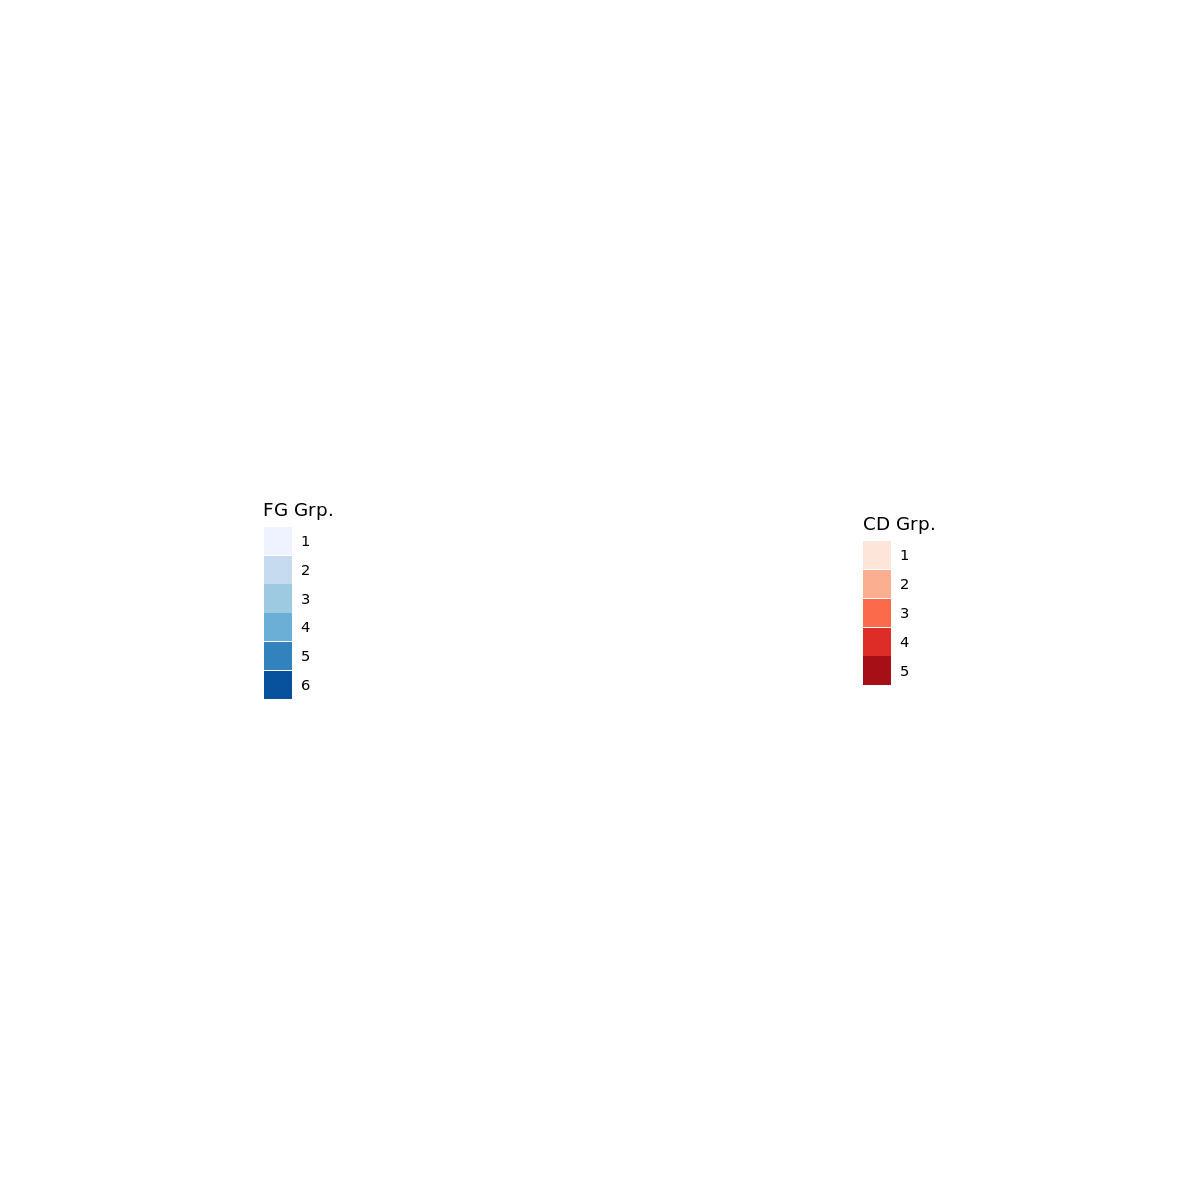

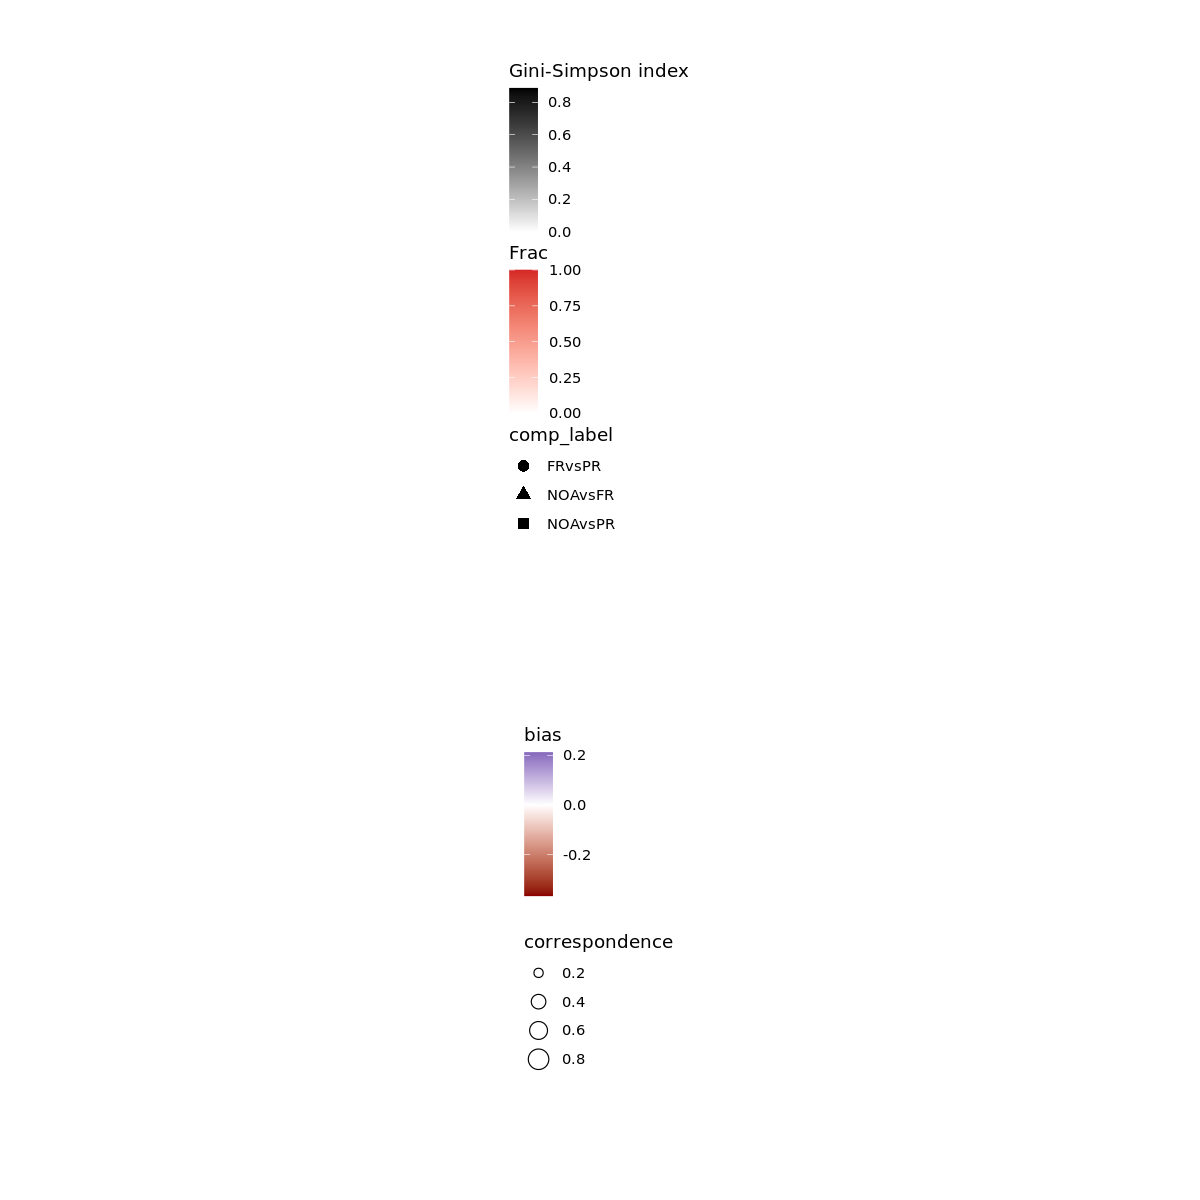

In [374]:
dleg_plot = grid.arrange(get_legend(dplotFG), get_legend(dplotCD), ncol=2);
pleg_plot = grid.arrange(get_legend(pfrac), get_legend(pdot), ncol=1);

In [375]:
dplotFGtbl = ggplot_gtable(ggplot_build(dplotFG + NoLegend()))
dplotCDtbl = ggplot_gtable(ggplot_build(dplotCD + NoLegend()))
pfracTbl = ggplot_gtable(ggplot_build(pfrac + NoLegend()))
pdotTbl = ggplot_gtable(ggplot_build(pdot + NoLegend()))
# legendTbl = ggplot_gtable(ggplot_build(as_ggplot(plot_legend)))
dplotCDtbl$heights = pdotTbl$heights
pfracTbl$heights = pdotTbl$heights
dplotFGtbl$widths = pdotTbl$widths

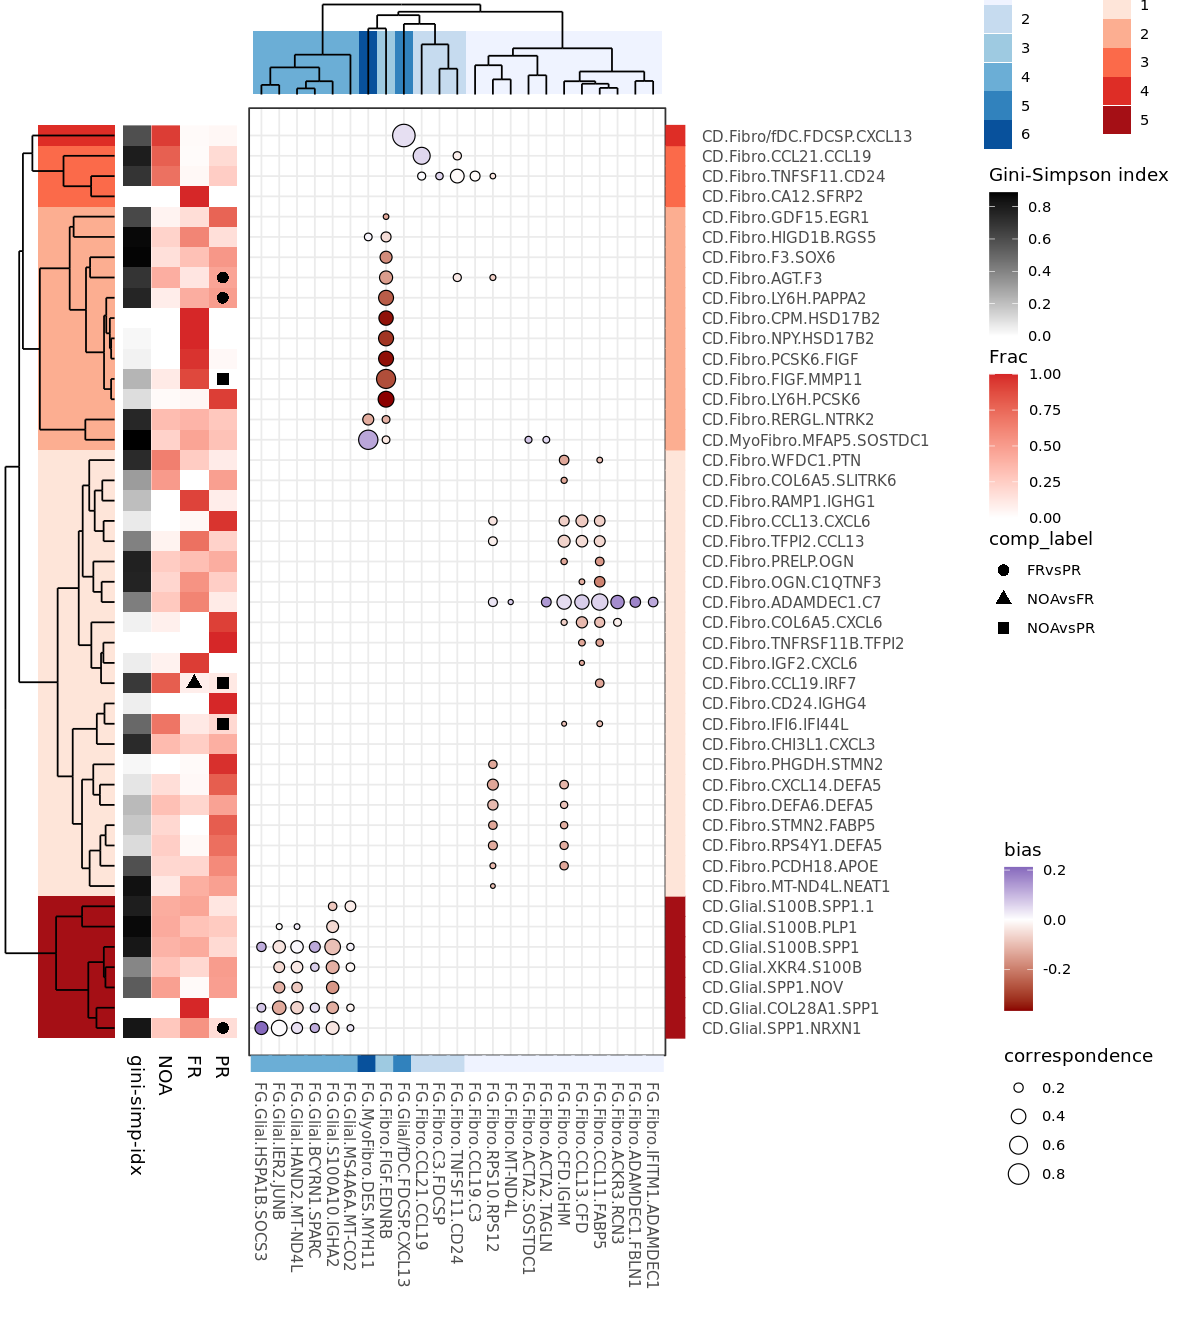

In [376]:
options(repr.plot.height=11, repr.plot.width=10)
grid.arrange(blank, blank, dplotFGtbl, dleg_plot,
             dplotCDtbl, pfracTbl, pdotTbl, pleg_plot, 
             ncol=4,
             widths=c(0.1, 0.1, 0.6, 0.2), 
             heights=c(0.075, 0.925)
             )

In [377]:
ggsave(plot=arrangeGrob(
            grid.arrange(blank, blank, dplotFGtbl, dleg_plot,
                dplotCDtbl, pfracTbl, pdotTbl, pleg_plot, 
                ncol=4,
                widths=c(0.1, 0.1, 0.6, 0.2), 
                heights=c(0.075, 0.925)
                ), 
            clip = "off"), 
       file=file.path(OUTDIR, sprintf("%s_correspondence.pdf", ct)),
            useDingbats = FALSE,
            width=8.5, height=11)

# make just pfrac plots

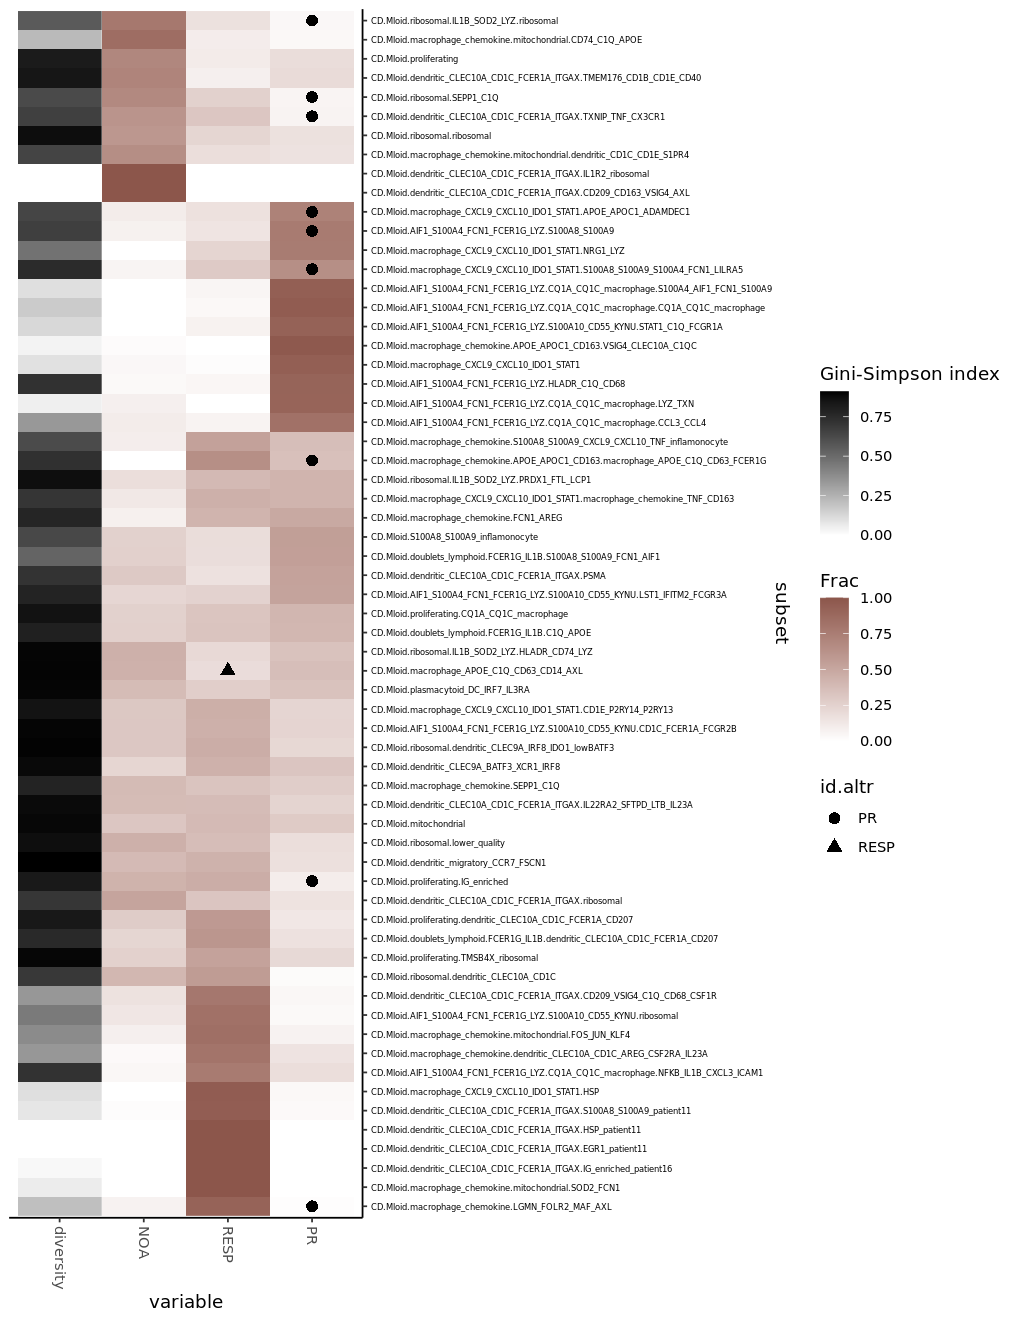

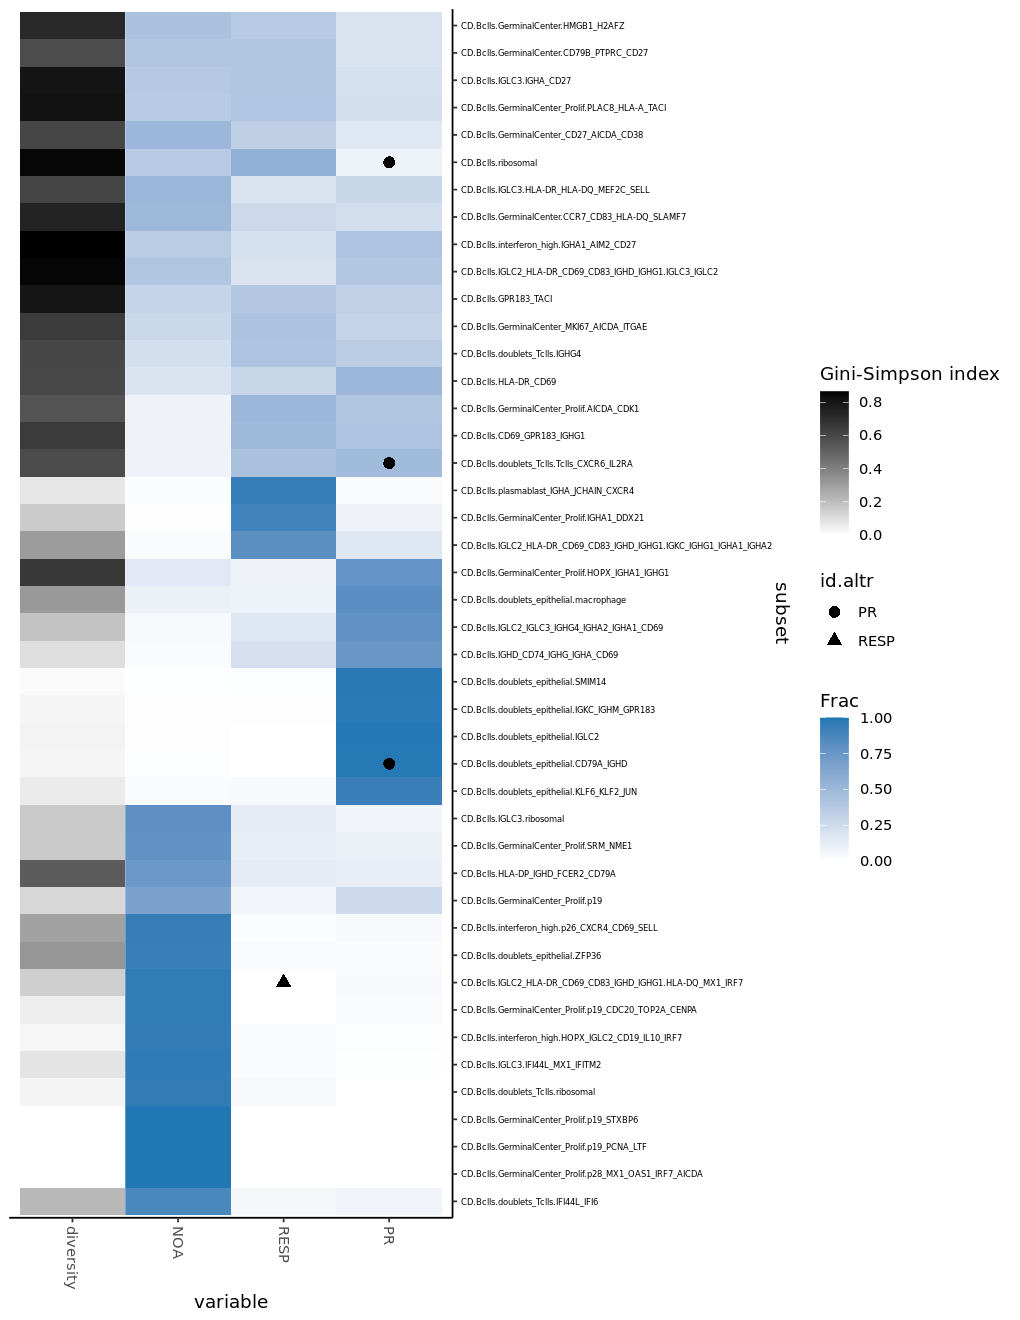

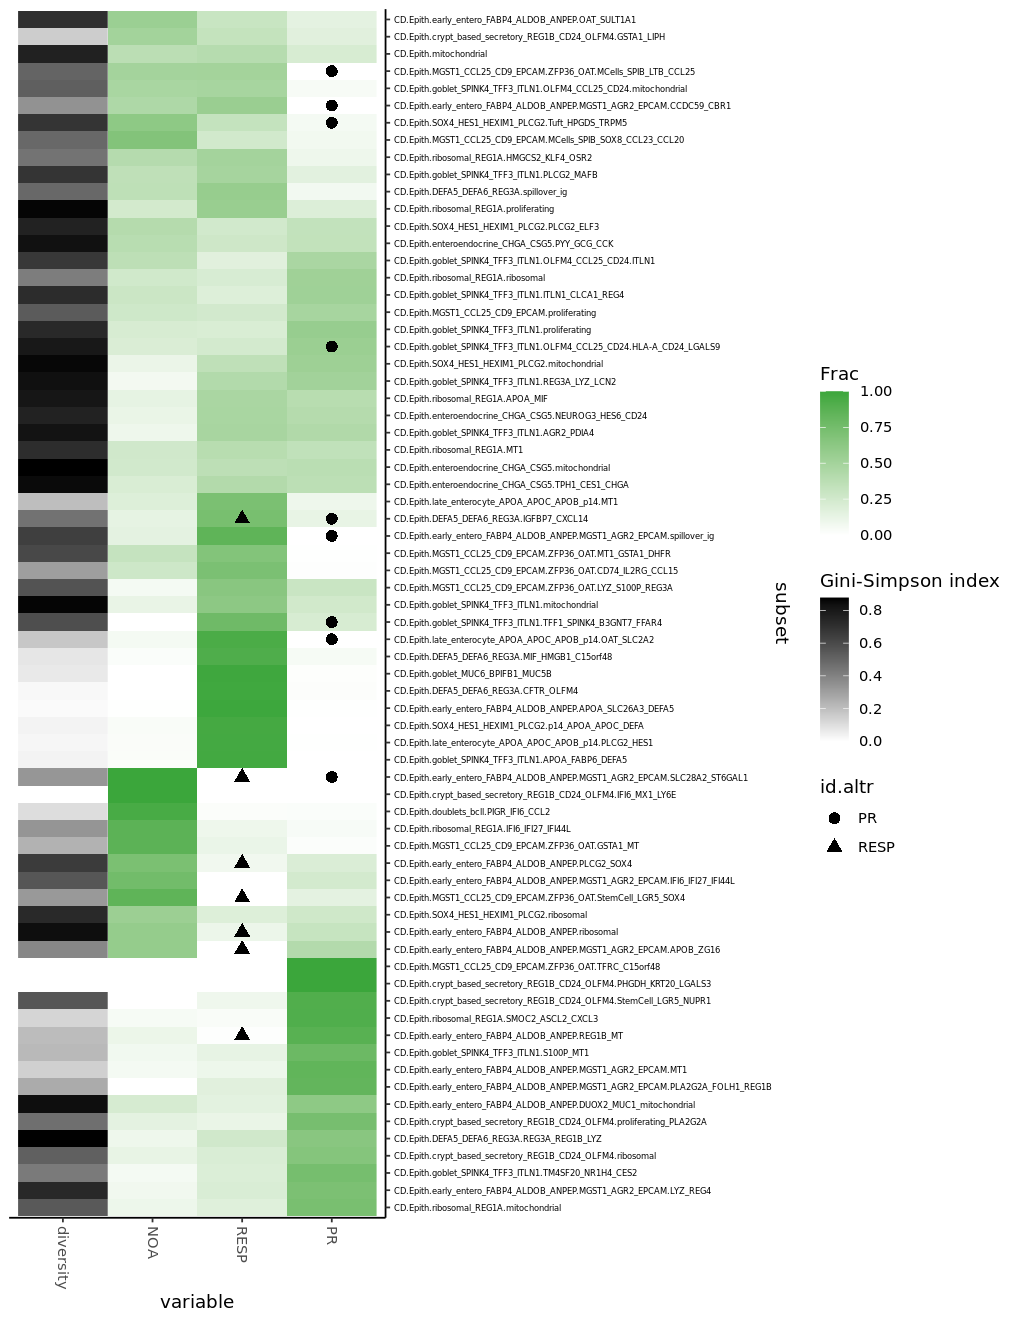

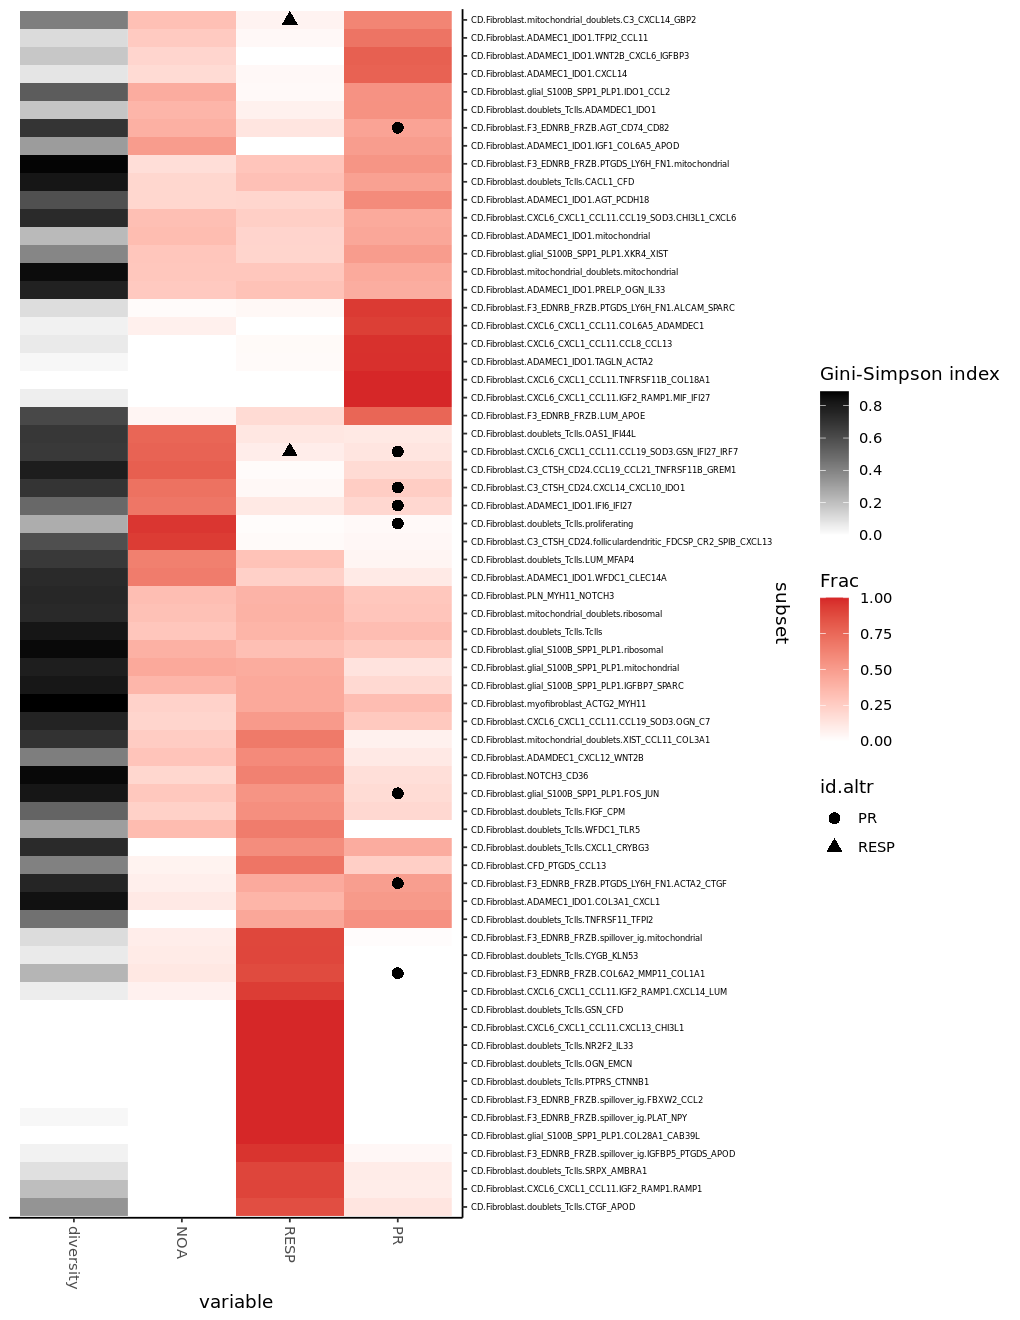

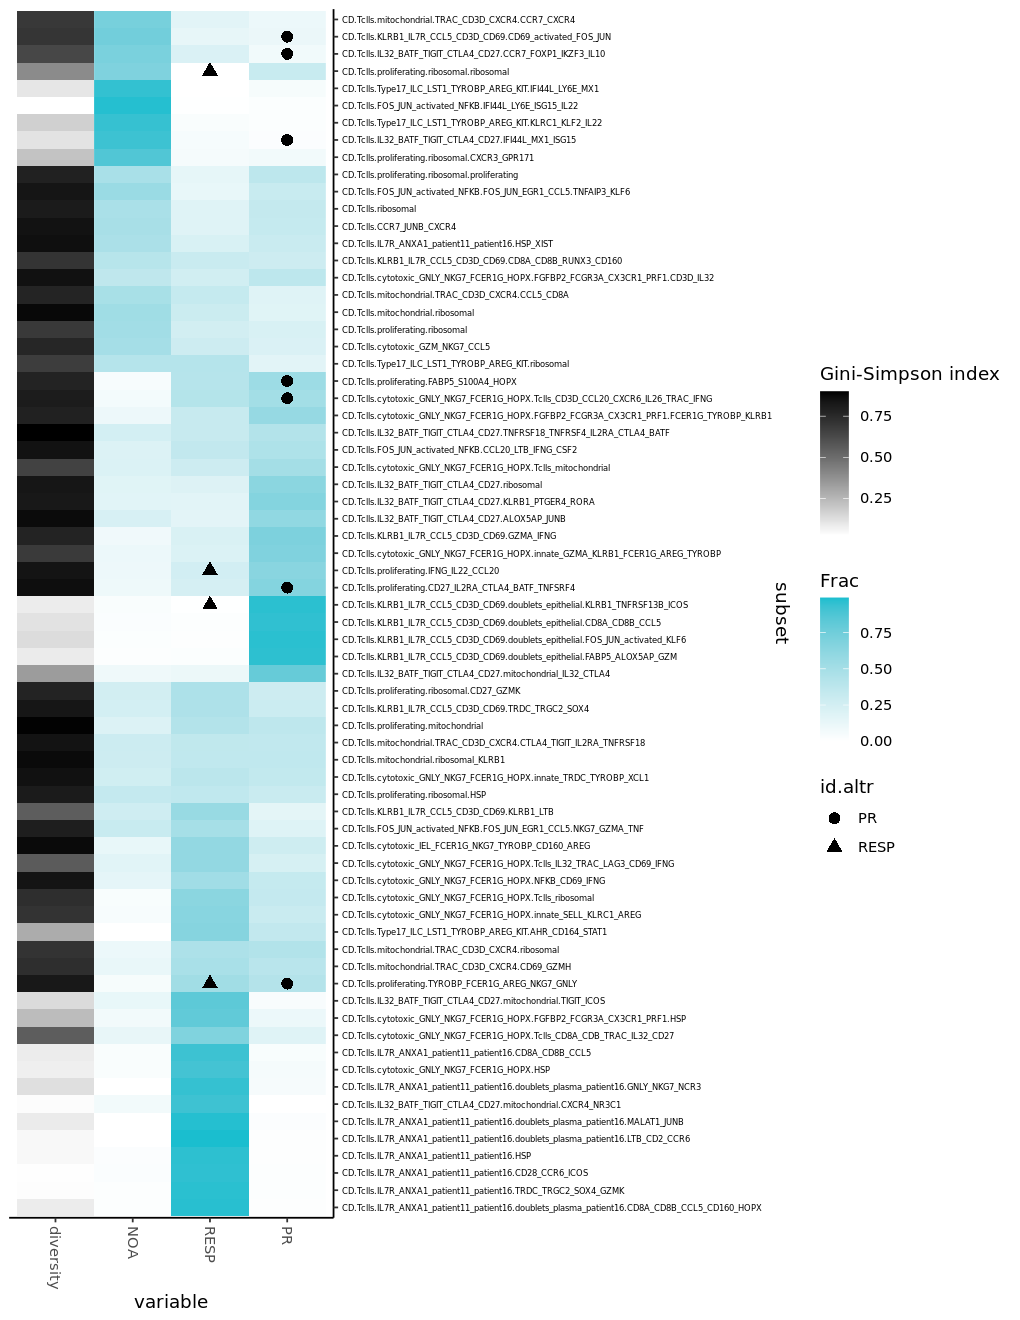

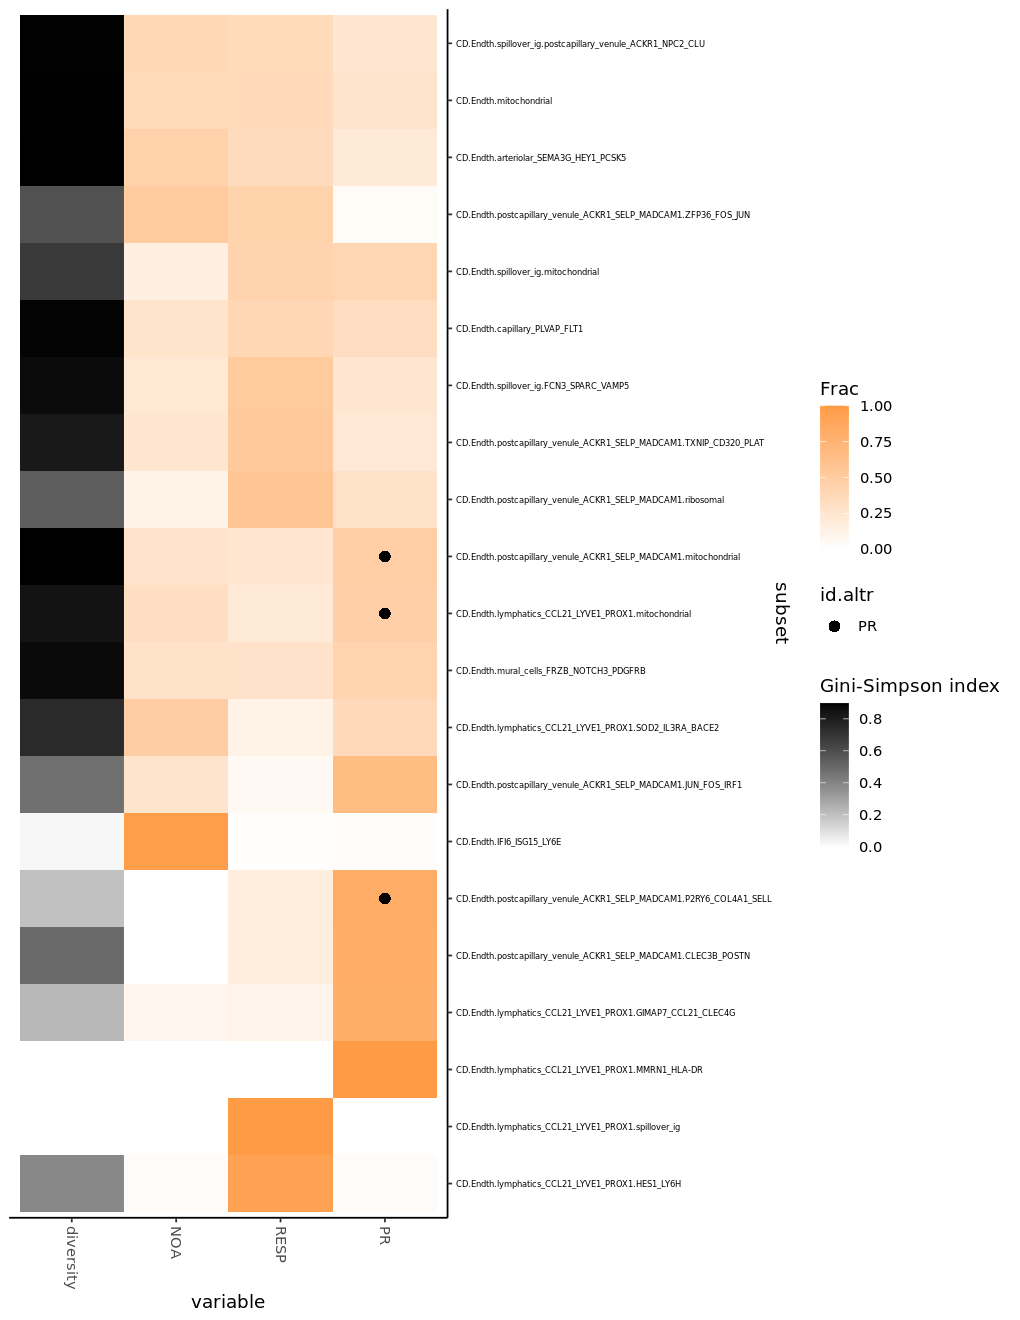

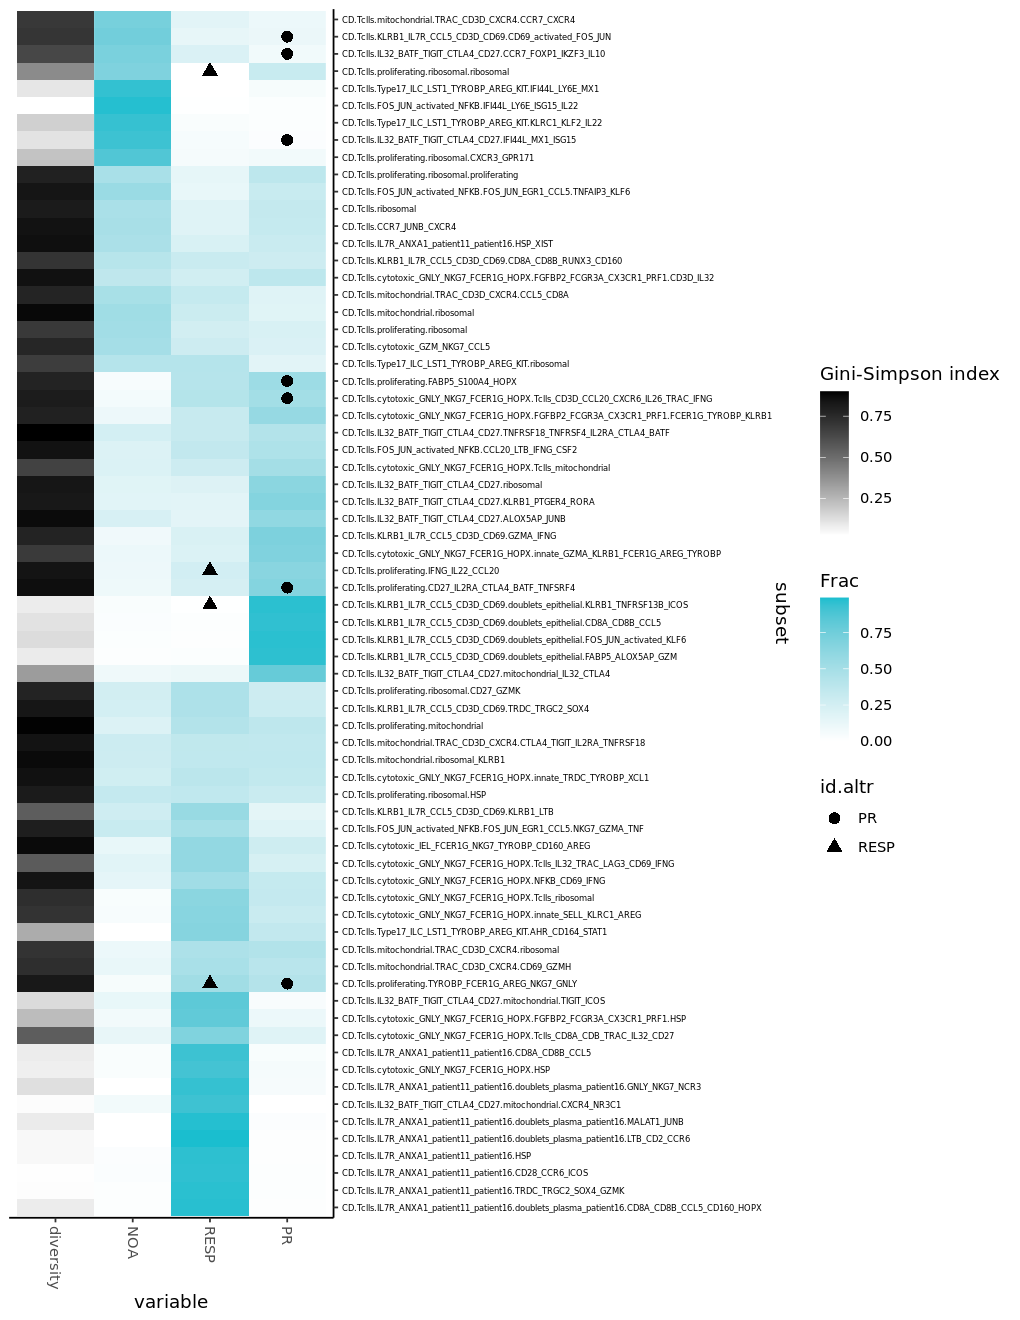

In [44]:
for (ct in names(celltype.colors)) {
    
    ct.meta = cd14_meta %>% filter(tier1name == ct & is_doublet=="False")
    
    tbl = ct.meta[, c("tierNname", "patient", "antiTNF_response")] %>%
        group_by(antiTNF_response, tierNname, patient) %>%
        summarize(count = length(patient)) %>%    
        group_by(patient) %>%
        mutate(normcount = ((count / sum(count)) * 1e6)) %>% 
        group_by(antiTNF_response, tierNname) %>% 
        summarize(value=mean(normcount)) %>% 
        reshape2::dcast(tierNname ~ antiTNF_response, value.var = "value") %>% 
        replace_na(list(NOA=0, PR=0, RESP=0)) %>%
        column_to_rownames("tierNname") %>%
        .[, c("NOA", "RESP", "PR")] %>%
        array %>% as.table %>% prop.table(margin=1) %>% 
        setNames(c("NOA", "RESP", "PR"))
    
    cdlinks = hclust(rdist::rdist(tbl, metric="euclidean"), method="complete")
    ordered_labels = rownames(tbl)[cdlinks$order]
    
    diversity = ct.meta %>% 
        group_by(tierNname) %>%
        summarize(diversity = 1 - sum(((table(patient)) / (length(patient)))^2)) %>%
        column_to_rownames("tierNname") %>%
        .[ordered_labels, ,drop=FALSE]
    diversity$tierNname = rownames(diversity)
    
    pfrac = ggplot(reshape2::melt(rownames_to_column(tbl, "subset"), id.vars="subset")) + 
        geom_raster(aes(y = subset, x = variable, fill=value), interpolate=FALSE) +
        scale_fill_gradient(low="white", high=celltype.colors[ct], name="Frac") +
        new_scale_fill() +
        geom_point(data=sigtest.df[sigtest.df$subset %in% ordered_labels, ],
                   inherit.aes=FALSE,
                   aes(y=subset,
                       x=id.altr,
                       shape=id.altr), size=3) +
        geom_raster(data=diversity, interpolate=FALSE,
                    aes(x="diversity", y=tierNname, fill=diversity)) +
        scale_fill_gradient(low="white", high="black", name="Gini-Simpson index") +
        scale_y_discrete(position = "right", limits = ordered_labels) +
        scale_x_discrete(limits=c("diversity", "NOA", 'RESP', "PR")) +
        theme_classic() +
        theme(axis.text.y.right = element_text(size=5, color="black"),
              axis.text.x = element_text(angle=-90, hjust=0, vjust=0.5))

    ggsave(plot=pfrac, file=paste0("~/2020PREDICTFIGS/patient_fraq/", ct, "_patient_cpm_with_sig.pdf"),
           useDingbats=FALSE,
           width=10, height=10)
    print(pfrac)
}

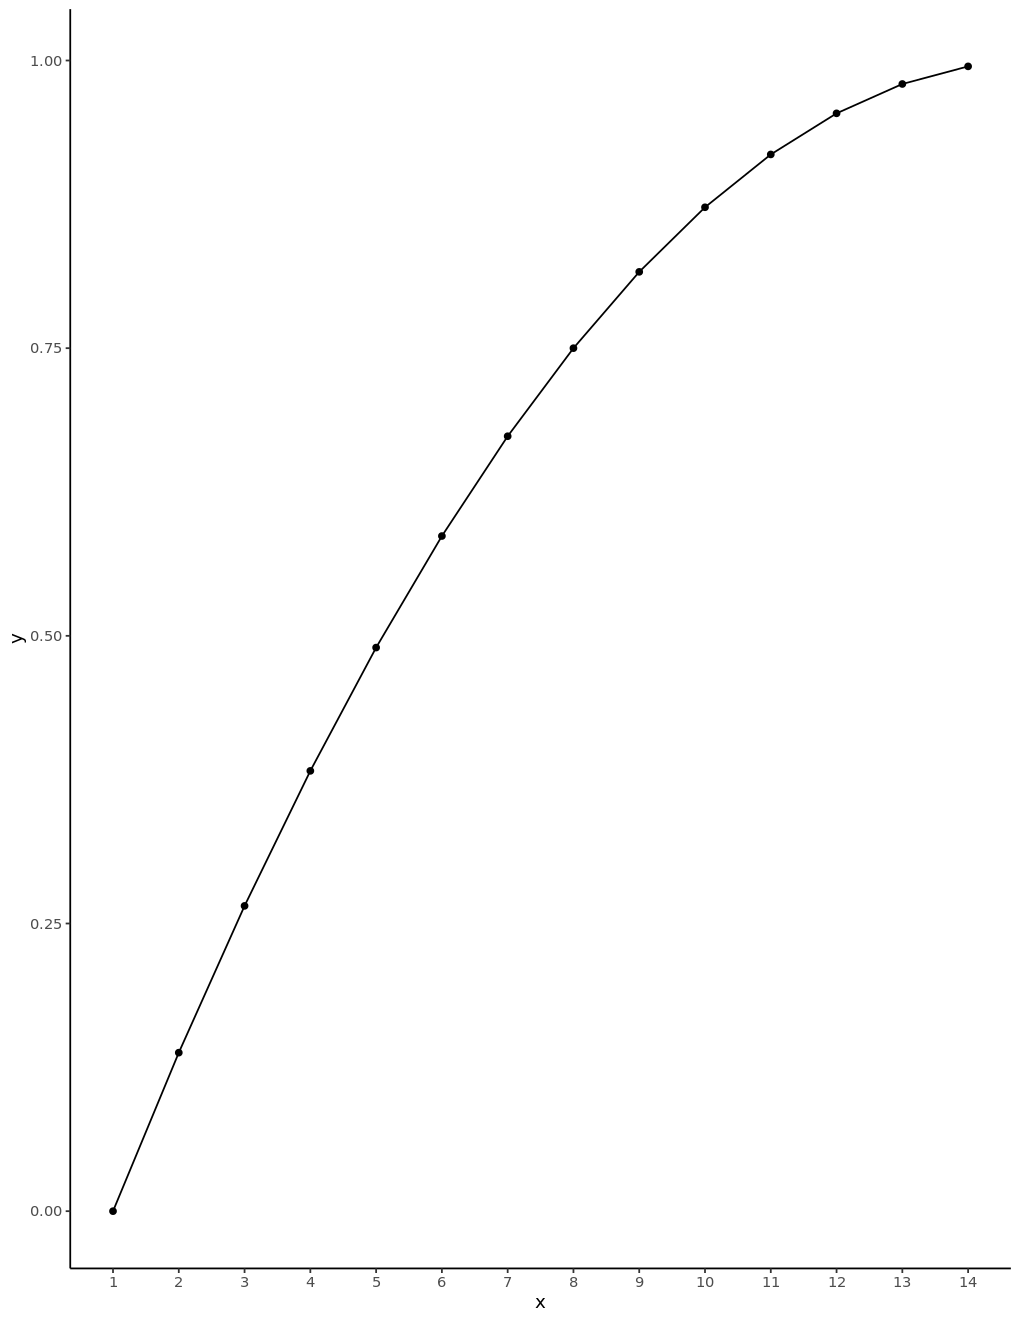

In [41]:
ggplot(data.frame(y = 1 - (14:1 / 14)^2, x = 1:14), aes(x=x, y=y)) +
    geom_line() + geom_point() +
    scale_x_continuous(breaks=1:14) +
    theme_classic()